<a href="https://colab.research.google.com/github/KushalPatil/NLP_Project/blob/main/Support%20Ticket%20Classification%20-%20EDA%20and%20Base%20Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
from time import time
from PIL import Image
from zipfile import ZipFile
import os, sys, itertools, re
import warnings, pickle, string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import spacy
import nltk
from nltk import tokenize

In [ ]:
#load the dataset
ticket = pd.read_excel('Automatic Ticket Assignment.xlsx')
ticket.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
#dataset description
ticket.shape[0]

8500

In [ ]:
ticket.shape[1]

4

In [ ]:
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


**NULL VALUES**

In [ ]:
ticket.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
ticket[pd.isnull(ticket).any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,_x000D_\n_x000D_\nreceived from: ohdrnswl.rezu...,ohdrnswl rezuibdt,GRP_34
3383,NaN,_x000D_\n-connected to the user system using t...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn._x000D_\n-connect...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn._x000D_\n-connect...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn._x000D_\n-connect...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn._x000D_\n-connect...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,_x000D_\n_x000D_\nreceived from: eqmuniov.ehxk...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [ ]:
ticket = ticket.dropna()
ticket = ticket.reset_index(drop=True)

In [ ]:
ticket.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

**TRANSLATE**

In [ ]:
import time
# List of column data to consider for translation
columns_trans = ['Short description','Description']

# Add a new column to store the detected language
ticket.insert(loc=2, column='Language', value=np.nan, allow_duplicates=True)

In [ ]:
!pip3 install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 1.4 MB 50.5 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=5595d8559ce4a127e55e8199b29c533447755010ec88cf4a1fb0344af60a0068
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
from googletrans import Translator, constants
translator = Translator()

In [ ]:
for idx in range(ticket.shape[0]):
    print(idx)
    # Instantiate Goslate class in each iteration
    # gt = Goslate(service_urls=URLs)
    lang = translator.detect(' '.join(ticket.loc[idx, columns_trans].tolist())).lang
    print(lang)
    translation = translator.translate(ticket.loc[idx, columns_trans].tolist(), dest='en', src='auto')
    row_iter = [translation[0].text,translation[1].text]
    ticket.loc[idx, columns_trans] = row_iter
    ticket.Language[idx] = lang


0
en


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Streaming output truncated to the last 5000 lines.
5991
en
5992
en
5993
en
5994
en
5995
en
5996
en
5997
en
5998
en
5999
en
6000
en
6001
en
6002
en
6003
en
6004
en
6005
en
6006
en
6007
en
6008
['en', 'de']
6009
en
6010
en
6011
en
6012
en
6013
en
6014
en
6015
en
6016
en
6017
en
6018
de
6019
en
6020
en
6021
en
6022
en
6023
en
6024
en
6025
en
6026
en
6027
en
6028
en
6029
de
6030
en
6031
en
6032
en
6033
en
6034
en
6035
en
6036
en
6037
en
6038
en
6039
de
6040
de
6041
en
6042
de
6043
en
6044
de
6045
da
6046
en
6047
de
6048
en
6049
en
6050
en
6051
en
6052
en
6053
en
6054
en
6055
en
6056
de
6057
de
6058
en
6059
de
6060
en
6061
en
6062
en
6063
de
6064
en
6065
en
6066
en
6067
de
6068
en
6069
de
6070
en
6071
en
6072
en
6073
en
6074
en
6075
en
6076
en
6077
en
6078
en
6079
en
6080
en
6081
en
6082
en
6083
en
6084
en
6085
en
6086
en
6087
en
6088
en
6089
co
6090
en
6091
en
6092
en
6093
is
6094
en
6095
en
6096
en
6097
co
6098
en
6099
en
6100
en
6101
en
6102
en
6103
en
6104
en
6105
en
6106
en
6107
en
610

In [ ]:
ticket

,Short description,Description,Language,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,en,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,en,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,en,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,en,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,en,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...,...
8486,emails not coming in from zz mail,_x000D_\n_x000D_\nreceived from: avglmrts.vhqm...,en,avglmrts vhqmtiua,GRP_29
8487,telephony_software issue,telephony_software issue,en,rbozivdq gmlhrtvp,GRP_0
8488,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,en,oybwdsgx oxyhwrfz,GRP_0
8489,machine is not working,i am unable to access the machine utilities to...,en,ufawcgob aowhxjky,GRP_62


In [ ]:
ticket.to_excel('translated_dataset.xlsx')

**Preprocessing**

In [ ]:
ticket = pd.read_excel('translated_dataset.xlsx')
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [ ]:
import string

In [ ]:
EMAIL_PATTERN = r"([\w.+-]+@[a-z\d-]+\.[a-z\d.-]+)"
PUNCT_PATTERN = r"[,|@|\|?|\\|$&*|%|\r|\n|.:|\s+|/|//|\\|/|\||-|<|>|;|(|)|=|+|#|-|\"|[-\]]|{|}]"
NUMER_PATTERN = r"(?<!RetainedEmailId)(\d+(?:\.\d+)?)"

def cleanseText(text):
    text = str(text).lower()
    email_dict = extract_email(text)
    for key in email_dict.keys():
        text = text.replace(email_dict[key], key)
    text = re.sub(NUMER_PATTERN, '', text)
    text = text.translate(str.maketrans("","", string.punctuation))
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r' {2,}', " ", text, flags=re.MULTILINE)
    text = text.replace('`',"'")
    for key in email_dict.keys():
        text = text.replace(key, email_dict[key])
    return text.strip()

def extract_email(text):
    unique_emailid = set(re.findall(EMAIL_PATTERN, text))
    email_replacement = dict()
    for idx, email in enumerate(unique_emailid):
        email_replacement[f'RetainedEmailId{idx}'] = email
    return email_replacement

In [ ]:
# Apply the cleaning function to entire dataset
ticket['Description'] = ticket['Description'].apply(cleanseText)
ticket['Short description'] = ticket['Short description'].apply(cleanseText)

In [ ]:
ticket.head()

,Unnamed: 0,Short description,Description,Language,Caller,Assignment group
0,0,login issue,verified user detailsemployee manager namexd c...,en,spxjnwir pjlcoqds,GRP_0
1,1,outlook,xd xd received from hmjdrvpb.komuaywn@gmail.co...,en,hmjdrvpb komuaywn,GRP_0
2,2,cant log in to vpn,xd xd received from eylqgodm.ybqkwiam@gmail.co...,en,eylqgodm ybqkwiam,GRP_0
3,3,unable to access hrtool page,unable to access hrtool page,en,xbkucsvz gcpydteq,GRP_0
4,4,skype error,skype error,en,owlgqjme qhcozdfx,GRP_0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

stemming and lemmatization

In [ ]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m spacy download en_core_web_md

2022-08-14 23:01:50.036911: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import spacy
spacy.load('en_core_web_md')

In [ ]:
# Initialize spacy 'en' medium model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Define a function to lemmatize the descriptions
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

In [ ]:
# Serialize the preprocessed dataset
ticket.to_csv('preprocessed_ticket.csv', index=False, encoding='utf_8_sig')
with open('preprocessed_ticket.pkl','wb') as f:
    pickle.dump(ticket, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Create new features of length and word count for both of the description columns
ticket.insert(1, 'sd_len', ticket['Short description'].astype(str).apply(len))
ticket.insert(2, 'sd_word_count', ticket['Short description'].apply(lambda x: len(str(x).split())))
ticket.insert(4, 'desc_len', ticket['Description'].astype(str).apply(len))
ticket.insert(5, 'desc_word_count', ticket['Description'].apply(lambda x: len(str(x).split())))
ticket.head()

,Unnamed: 0,sd_len,sd_word_count,Short description,desc_len,desc_word_count,Description,Language,Caller,Assignment group
0,0,11,2,login issue,195,32,verified user detailsemployee manager namexd c...,en,spxjnwir pjlcoqds,GRP_0
1,1,7,1,outlook,196,30,xd xd received from hmjdrvpb.komuaywn@gmail.co...,en,hmjdrvpb komuaywn,GRP_0
2,2,18,5,cant log in to vpn,93,16,xd xd received from eylqgodm.ybqkwiam@gmail.co...,en,eylqgodm ybqkwiam,GRP_0
3,3,28,5,unable to access hrtool page,28,5,unable to access hrtool page,en,xbkucsvz gcpydteq,GRP_0
4,4,11,2,skype error,11,2,skype error,en,owlgqjme qhcozdfx,GRP_0


The distribution of Assignment groups:

Plots how the assignments groups are scattered across the dataset. The bar chart, histogram and pie chart tells the frequency of any ticket assigned to any group OR the tickets count for each group.

In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=195a6e66a64cadd82fad26e8ea40df4cd68386d8ae2d1e6df3c2c9dafa651b1c
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

In [ ]:
from plotly.offline import iplot

In [ ]:
# Top 5 callers in each assignment group
top_n = 5
s = ticket['Caller'].groupby(ticket['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



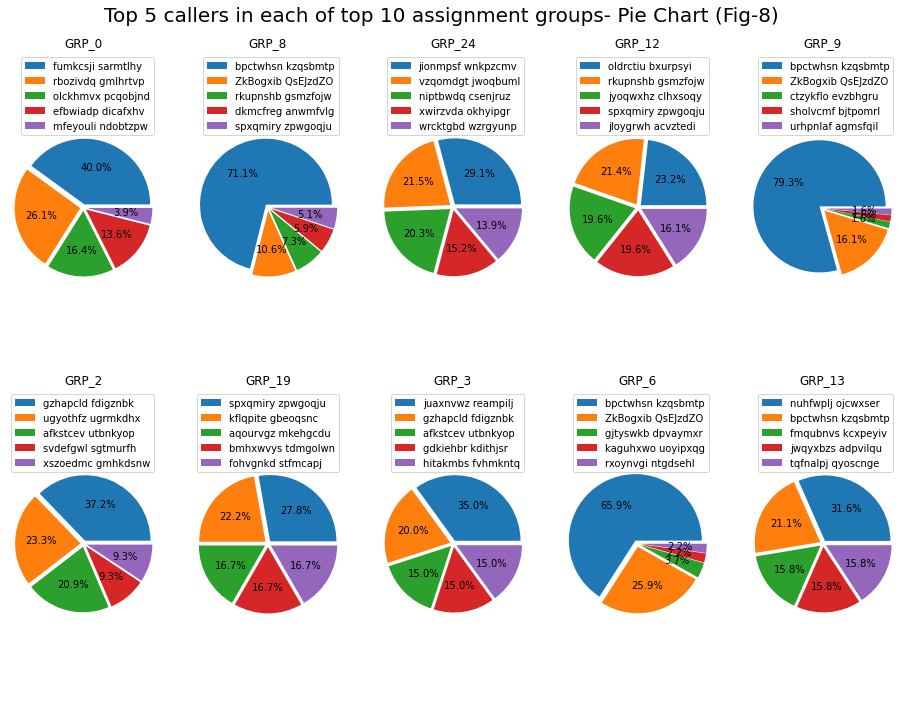

In [ ]:
# Visualize Top 5 callers in each of top 10 assignment groups
assgn_grp = pd.DataFrame(ticket.groupby('Assignment group').size(),columns = ['Count']).reset_index()
top_n = 10
top_grps = assgn_grp.nlargest(top_n, 'Count')['Assignment group'].tolist()

fig_cols = 5
fig_rows = int(np.ceil(top_n/fig_cols))
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13,9.5))
fig.suptitle('Top 5 callers in each of top 10 assignment groups- Pie Chart (Fig-8)', y=1, va= 'bottom', size='20')
for row in range(fig_rows):
    for col in range(fig_cols):
        grp_n = fig_cols * row + col
        if grp_n < top_n:
            xs = caller_grp.xs(top_grps[grp_n])
            _ = axes[row,col].pie(xs, autopct='%1.1f%%', explode=[0.05]*5)
            axes[row,col].legend(labels=xs.index,loc="best")
            axes[row,col].axis('equal')
            axes[row,col].set_title(top_grps[grp_n])

plt.tight_layout()

In [ ]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'Following {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\n')
print(uni_mul_caller)

mul_caller

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


Caller
Assignment group Caller                   
GRP_1            spxqmiry zpwgoqju       3
GRP_10           ihfkwzjd erbxoyqk       6
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3
GRP_11           tghrloks jbgcvlmf       2
...                                    ...
GRP_73           kcnosyae zlpmfxgs       1
GRP_8            ZkBogxib QsEJzdZO      54
GRP_9            ctzykflo evzbhgru       3
                 sholvcmf bjtpomrl       3
                 urhpnlaf agmsfqil       3

[281 rows x 1 columns]

N-Grams

In [ ]:
# Merge the Short descrition and Description column texts to create a new column
ticket.insert(loc=8, 
              column='Summary', 
              allow_duplicates=True, 
              value=list(ticket['Short description'].str.strip() + ' ' + ticket['Description'].str.strip()))
# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

In [ ]:
# Top 50 Unigrams before removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(uni_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Unigrams in Summary')

# Top 50 Unigrams after removing stop words
uni_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(uni_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Unigrams in Summary without stop words')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [ ]:
# Top 50 Bigrams before removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(bi_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Bigrams in Summary')

# Top 50 Bigrams after removing stop words
bi_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(bi_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Bigrams in Summary without stop words')

In [ ]:
# Top 50 Trigrams before removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(tri_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Trigrams in Summary')

# Top 50 Trigrams after removing stop words
tri_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(tri_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Trigrams in Summary without stop words')

Word Cloud

In [ ]:
def generate_word_clod(corpus):
    # mask = np.array(Image.open('cloud2.png'))
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOP_WORDS,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

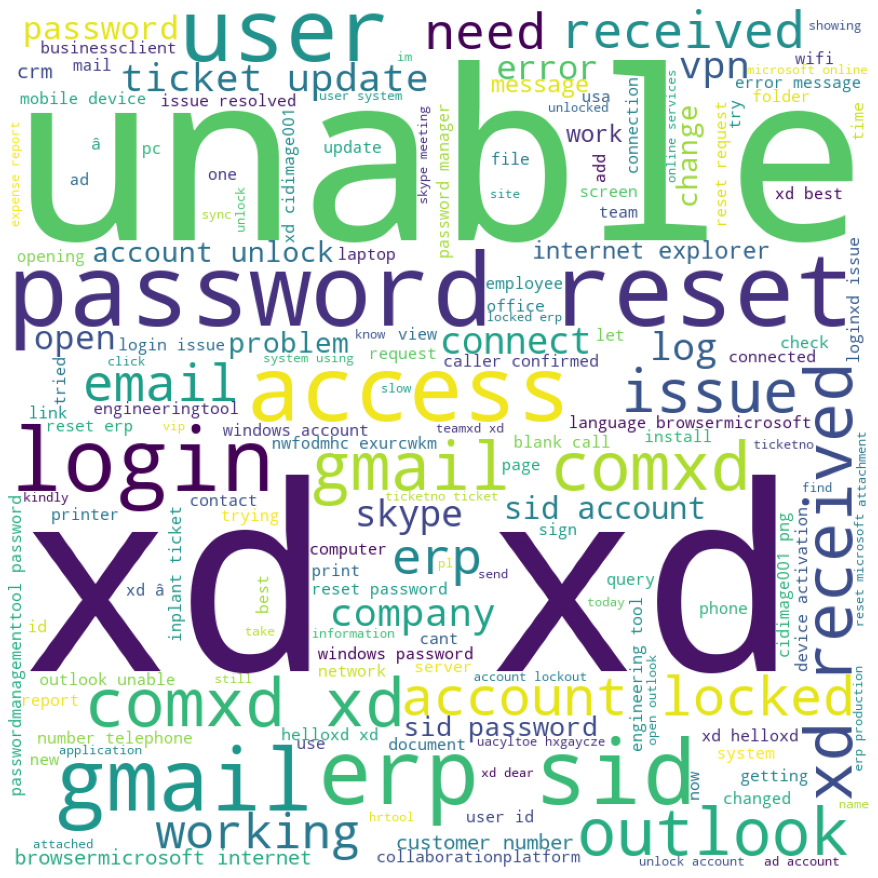

In [ ]:
# Word Cloud for all tickets assigned to GRP_0
generate_word_clod(' '.join(ticket[ticket['Assignment group'] == 'GRP_0'].Summary.str.strip()))

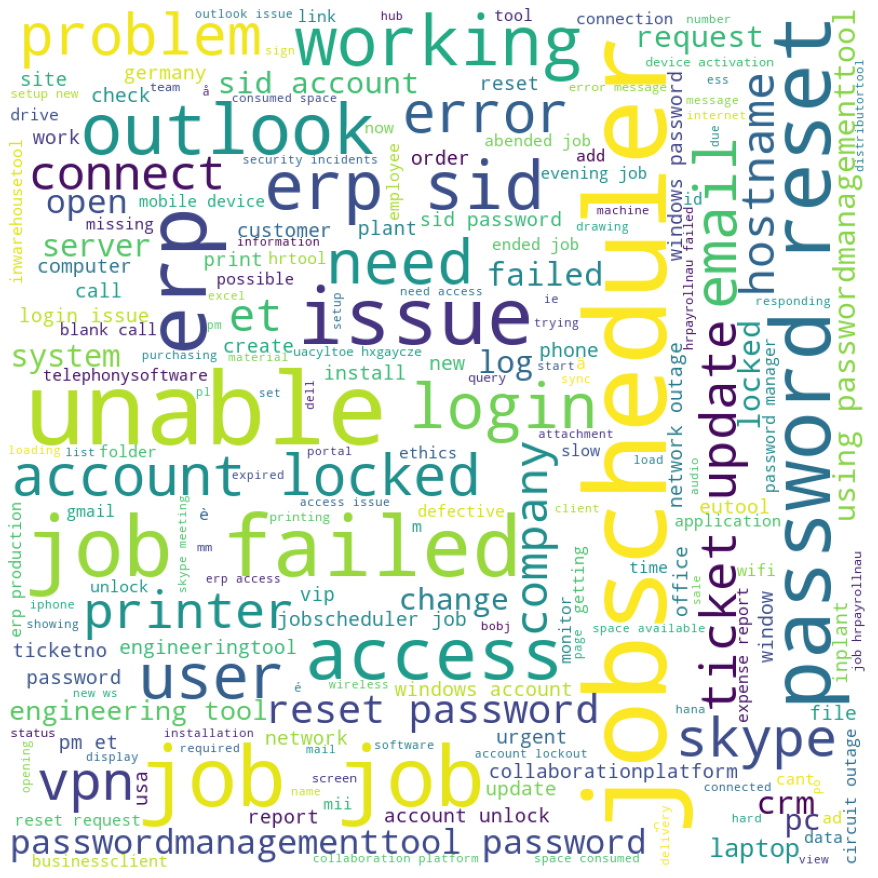

In [ ]:
# Generate wordcloud for ticket Short description
generate_word_clod(' '.join(ticket['Short description'].str.strip()))

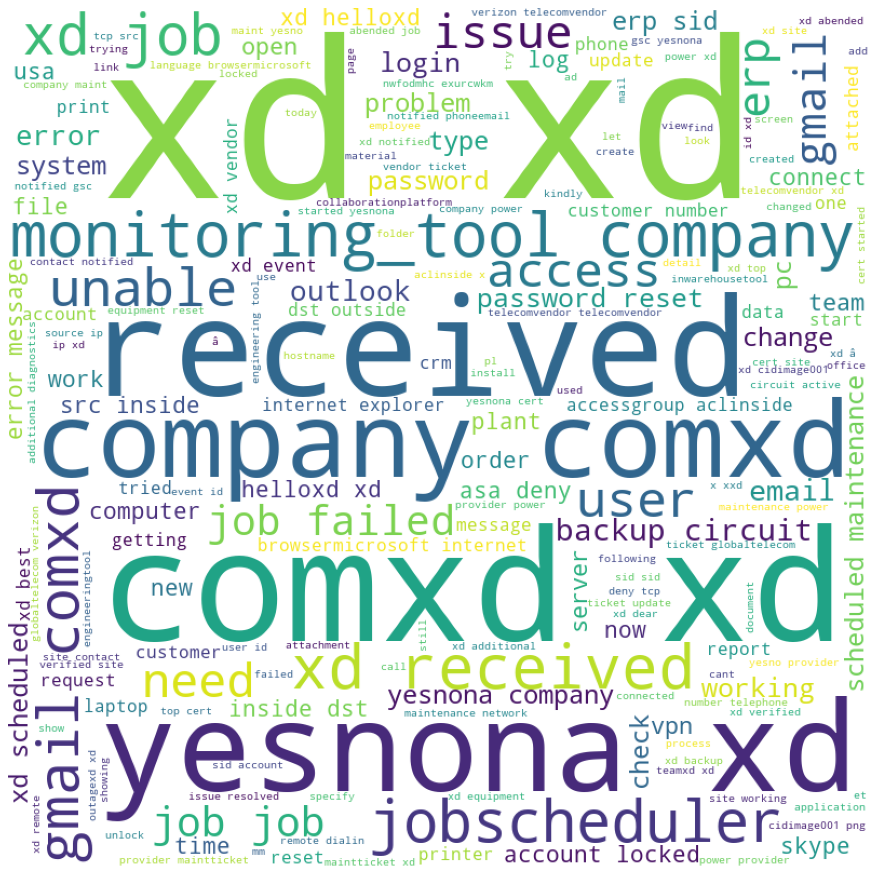

In [ ]:
# Generate wordcloud for ticket Description
generate_word_clod(' '.join(ticket.Description.str.strip()))

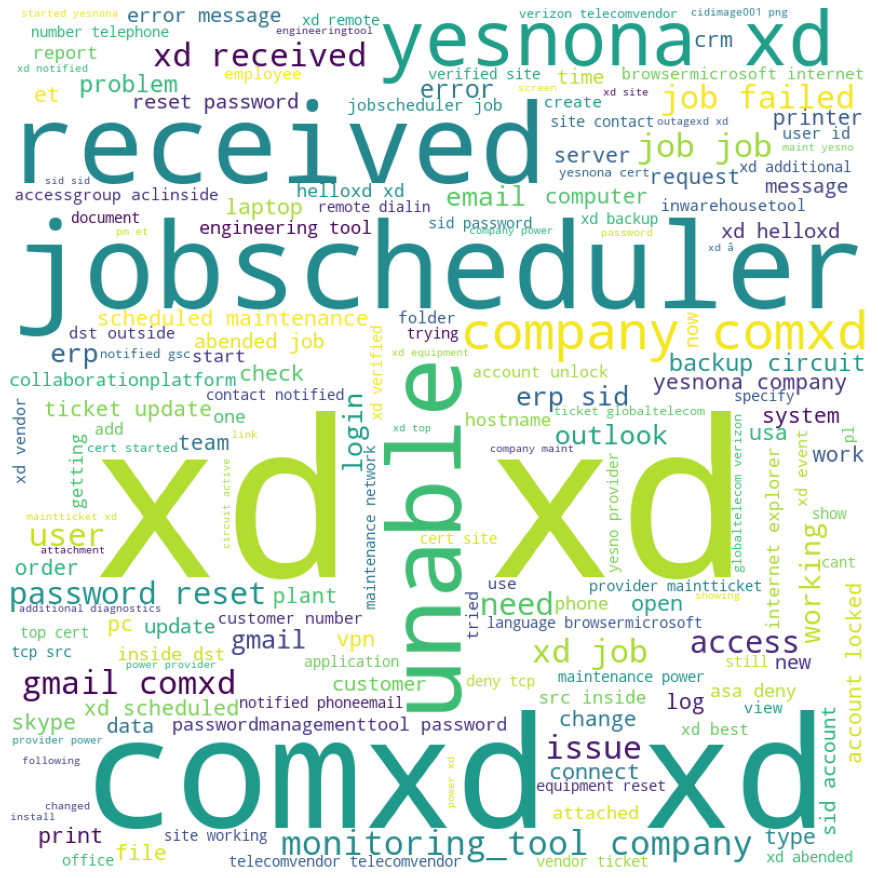

In [ ]:
# Generate wordcloud for ticket Summary
generate_word_clod(' '.join(ticket.Summary.str.strip()))

In [ ]:
# Serializing the dataset after EDA
with open('model_ready.pkl','wb') as f:
    pickle.dump(ticket, f, pickle.HIGHEST_PROTOCOL)

Model Building


In [ ]:
# Create a target categorical column
ticket['target'] = ticket['Assignment group'].astype('category').cat.codes
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8491 entries, 0 to 8490
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         8491 non-null   int64 
 1   sd_len             8491 non-null   int64 
 2   sd_word_count      8491 non-null   int64 
 3   Short description  8491 non-null   object
 4   desc_len           8491 non-null   int64 
 5   desc_word_count    8491 non-null   int64 
 6   Description        8491 non-null   object
 7   Language           8491 non-null   object
 8   Summary            8491 non-null   object
 9   Caller             8491 non-null   object
 10  Assignment group   8491 non-null   object
 11  target             8491 non-null   int8  
dtypes: int64(5), int8(1), object(6)
memory usage: 738.1+ KB


In [ ]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')

In [ ]:
# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(ticket.Summary, 
                                                    ticket.target, 
                                                    test_size=0.20, 
                                                    random_state=42)
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (6792,) (1699,)
Shape of the test set: (6792,) (1699,)


Naive Bayes Classifier


In [ ]:
run_classification(MultinomialNB(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])
Training accuracy: 55.55%
Testing accuracy: 55.39%
Confusion matrix:
 [[795   0   0 ...   0   0   0]
 [  3   0   0 ...   0   1   0]
 [ 13   0   0 ...   0  12   0]
 ...
 [  1   0   0 ...   0   0   0]
 [ 14   0   0 ...   0 121   0]
 [ 16   0   0 ...   0  32   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71       795
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00         4
           4       0.64      0.19      0.29        48
           5       0.00      0.00      0.00        27
           6       0.00      0.00      0.00        27
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



K-nearest Neighbor

In [ ]:
run_classification(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])
Training accuracy: 70.48%
Testing accuracy: 63.45%
Confusion matrix:
 [[781   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [ 11   0   7 ...   0   5   1]
 ...
 [  1   0   0 ...   0   0   0]
 [ 15   0   2 ...   0 110   6]
 [ 15   0   0 ...   0  21   9]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.98      0.76       795
           1       0.00      0.00      0.00         6
           2       0.78      0.28      0.41        25
           3       1.00      0.50      0.67         4
           4       0.62      0.48      0.54        48
           5       0.64      0.26      0.37        27
           6       0.89      0.30      0.44        27
           7       1.00      0.10      0.18        10
           8       0.50      0.06      0.11        17
           9       1.00      0.47   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Support Vector Machine (SVM)

In [ ]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])
Training accuracy: 93.48%
Testing accuracy: 69.04%
Confusion matrix:
 [[750   0   1 ...   0   0   4]
 [  2   0   0 ...   0   0   0]
 [  3   0   9 ...   0   5   3]
 ...
 [  1   0   0 ...   0   0   0]
 [  5   1   2 ...   0 114   5]
 [  9   0   0 ...   0  21  14]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       795
           1       0.00      0.00      0.00         6
           2       0.60      0.36      0.45        25
           3       1.00      0.50      0.67         4
           4       0.58      0.67      0.62        48
           5       0.55      0.63      0.59        27
           6       0.72      0.48      0.58        27
           7       0.75      0.30      0.43        10
           8       0.75      0.18      0.29        17
           9       0.94      0.84      0.89    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# SVM with RBF kernel
run_classification(SVC(kernel='rbf'), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC())])
Training accuracy: 81.61%
Testing accuracy: 64.04%
Confusion matrix:
 [[790   0   0 ...   0   0   0]
 [  3   0   0 ...   0   0   0]
 [ 13   0   6 ...   0   6   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  8   0   2 ...   0 120   0]
 [ 15   0   0 ...   0  27   3]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.99      0.76       795
           1       0.00      0.00      0.00         6
           2       0.75      0.24      0.36        25
           3       0.00      0.00      0.00         4
           4       0.62      0.54      0.58        48
           5       1.00      0.37      0.54        27
           6       1.00      0.22      0.36        27
           7       1.00      0.10      0.18        10
           8       0.00      0.00      0.00        17
           9       0.95      0.95      0.95        19

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Decision Tree

In [ ]:
run_classification(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])
Training accuracy: 95.45%
Testing accuracy: 56.03%
Confusion matrix:
 [[638   0   5 ...   0   2   4]
 [  1   1   0 ...   0   0   0]
 [  5   0   6 ...   0   5   1]
 ...
 [  0   0   0 ...   0   0   0]
 [  4   1   2 ...   0 104   6]
 [  3   0   1 ...   0  21   9]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       795
           1       0.17      0.17      0.17         6
           2       0.33      0.24      0.28        25
           3       0.00      0.00      0.00         4
           4       0.38      0.44      0.41        48
           5       0.14      0.11      0.12        27
           6       0.18      0.15      0.16        27
           7       0.18      0.20      0.19        10
           8       0.18      0.24      0.21        17
           9       0.95      0.95 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

Random Forest

In [ ]:
run_classification(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Training accuracy: 95.45%
Testing accuracy: 63.86%
Confusion matrix:
 [[787   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [ 13   0   6 ...   0   5   1]
 ...
 [  1   0   0 ...   0   0   0]
 [  7   1   2 ...   0 115   5]
 [ 15   0   0 ...   0  21   9]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.99      0.76       795
           1       0.00      0.00      0.00         6
           2       0.75      0.24      0.36        25
           3       0.00      0.00      0.00         4
           4       0.59      0.46      0.52        48
           5       0.67      0.15      0.24        27
           6       1.00      0.30      0.46        27
           7       1.00      0.10      0.18        10
           8       0.00      0.00      0.00        17
           9       0.94      0.89 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Neural Network

In [ ]:
#Path where you want to save the weights, model and checkpoints
model_path = "Weights/"
%mkdir Weights

# Define model callbacks
def call_backs(name):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=100)
    model_checkpoint =  ModelCheckpoint(model_path + name + '_epoch{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=False,
                                                               mode='min',
                                                               period=1)
    return [model_checkpoint, early_stopping]

Deep Neural Networks

In [ ]:
# Function to build Deep NN
def Build_Model_DNN_Text(shape, nClasses, dropout=0.3):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(ticket.Summary)
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

# Instantiate the network
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 75)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                        

In [ ]:
#model_DNN.fit(X_train_tfidf, y_train,validation_data=(X_test_tfidf, y_test), callbacks=call_backs("NN"), epochs=10,  batch_size=128, verbose=3)
#predicted = model_DNN.predict(X_test_tfidf)

Extract Glove Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-08-14 23:34:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-14 23:34:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-14 23:34:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Check if it is already extracted else Open the zipped file as readonly
if not os.path.isfile('glove.6B/glove.6B.100d.txt'):
    glove_embeddings = 'glove.6B.zip'
    with ZipFile(glove_embeddings, 'r') as archive:
        archive.extractall('glove.6B')

# List the files under extracted folder
os.listdir('glove.6B')

['glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt']

Convolutional Neural Networks (CNN)

In [ ]:
gloveFileName = 'glove.6B/glove.6B.200d.txt'
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM=200
MAX_NB_WORDS=75000

# Function to generate Embedding
def loadData_Tokenizer(X_train, X_test,filename):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)


embedding_matrix = []

def buildEmbed_matrices(word_index,embedding_dim):
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])), "into shape",str(len(embedding_vector)),
                      " Please make sure your"" EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# Generate Glove embedded datasets
X_train_Glove, X_test_Glove, word_index, embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

Found 18061 unique tokens.
(8491, 500)
Total 400000 word vectors.


In [ ]:
def Build_Model_CNN_Text(word_index, embeddings_matrix, nclasses,dropout=0.5):
    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """
    model = Sequential()
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_batch1 = BatchNormalization()(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_batch1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_batch2 = BatchNormalization()(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_batch2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
# Train the network and run classification
model_CNN = Build_Model_CNN_Text(word_index,embedding_matrix, 75)
run_classification(model_CNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='CNN')

Filter   5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 200)     3612400     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 499, 128)     51328       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 498, 128)     76928       ['embedding[0][0]']              
                                                                                   

None
Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 3.0918 - accuracy: 0.4335
Epoch 1: val_loss improved from inf to 3.03192, saving model to Weights/CNN_epoch01_loss3.0319.h5
54/54 [==============================] - 279s 5s/step - loss: 3.0918 - accuracy: 0.4335 - val_loss: 3.0319 - val_accuracy: 0.4679
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 2.5400 - accuracy: 0.4695
Epoch 2: val_loss did not improve from 3.03192
54/54 [==============================] - 299s 6s/step - loss: 2.5400 - accuracy: 0.4695 - val_loss: 3.6594 - val_accuracy: 0.3019
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 2.3505 - accuracy: 0.5085
Epoch 3: val_loss did not improve from 3.03192
54/54 [==============================] - 276s 5s/step - loss: 2.3505 - accuracy: 0.5085 - val_loss: 3.5825 - val_accuracy: 0.4873
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 2.1879 - accuracy: 0.5306
Epoch 4: val_loss did not improve fro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Recurrent Neural Networks (RNN)

In [ ]:
def Build_Model_RNN_Text(word_index, embeddings_matrix, nclasses,dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_matrix, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=100, dropout=0.5):
    word_index in word index ,
    embeddings_matrix is embeddings_matrix, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    gru_node = 32
    
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='sgd',
                      metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
# Train the network and run classification
model_RNN = Build_Model_RNN_Text(word_index,embedding_matrix, 75)
run_classification(model_RNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='RNN')

Recurring Convolution Neural Network(RCNN)

In [ ]:
def Build_Model_RCNN_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
# Train the network and run classification
model_RCNN = Build_Model_CNN_Text(word_index,embedding_matrix, 75)
run_classification(model_RCNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='RCNN')

RNN with LSTM networks


In [ ]:
EMBEDDING_DIM = 100
gloveFileName = 'glove.6B/glove.6B.100d.txt'

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Activation
from keras.layers import Flatten, Permute, merge, Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input, Dense, multiply, concatenate, Dropout
from keras.layers import GRU, Bidirectional


def Build_Model_LTSM_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(gru_node, recurrent_dropout=0.2)))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

model_LTSM = Build_Model_LTSM_Text(word_index,embedding_matrix, 75)
run_classification(model_LTSM, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='LSTM')

Found 18061 unique tokens.
(8491, 500)
Total 400000 word vectors.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          1806200   
                                                                 
 dropout_9 (Dropout)         (None, 500, 100)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 499, 256)          51456     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 249, 256)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 248, 256)          131328    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 124, 256)        

None
Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 2.6616 - accuracy: 0.4589
Epoch 1: val_loss improved from inf to 2.55802, saving model to Weights/LSTM_epoch01_loss2.5580.h5
54/54 [==============================] - 413s 7s/step - loss: 2.6616 - accuracy: 0.4589 - val_loss: 2.5580 - val_accuracy: 0.4679
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 2.5650 - accuracy: 0.4672
Epoch 2: val_loss improved from 2.55802 to 2.54078, saving model to Weights/LSTM_epoch02_loss2.5408.h5
54/54 [==============================] - 358s 7s/step - loss: 2.5650 - accuracy: 0.4672 - val_loss: 2.5408 - val_accuracy: 0.4679
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 2.4513 - accuracy: 0.4654
Epoch 3: val_loss improved from 2.54078 to 2.33331, saving model to Weights/LSTM_epoch03_loss2.3333.h5
54/54 [==============================] - 353s 7s/step - loss: 2.4513 - accuracy: 0.4654 - val_loss: 2.3333 - val_accuracy: 0.5244
Epoch 4/10
54/54 [

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

